In [1]:
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import matplotlib.pyplot as plt
# from numba import prange, njit
import time
from mpl_toolkits.mplot3d import Axes3D
from fireworks.ic import ic_tf as fic_tf 
from fireworks.ic import ic as fic
import fireworks.nbodylib.integrators as fint
import fireworks.nbodylib.dynamics as fdyn
import fireworks.nbodylib.timesteps as ftim
from tqdm.notebook import tqdm
from fireworks.particles import Particles_tf,Particles
import multiprocessing
from multiprocessing import Pool, Manager
import psutil
import pandas as pd
import cProfile

tf.config.optimizer.set_jit(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # Ensure TensorFlow is configured to use the GPU
assert tf.test.is_gpu_available(), "No GPU detected or TensorFlow is not configured to use it."
 

2024-06-03 15:16:47.830151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 15:16:47.830195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 15:16:47.831545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 15:16:47.837869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 15:16:48.511754: W tensorflow/compiler/tf2

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-06-03 15:16:50.143643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 15:16:50.185882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 15:16:50.186134: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## GPU and Direct

In [2]:
def initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass,seed):
    
    particles = fic.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass,seed =seed,
    )
    print(f'Loaded {n_particles} particles \n')
    
    assert len(particles) == n_particles
    assert np.min(particles.pos) >= min_pos and np.max(particles.pos) <= max_pos
    assert np.min(particles.vel) >= min_vel and np.max(particles.vel) <= max_vel
    assert np.min(particles.mass) >= min_mass and np.max(particles.mass) <= max_mass
    return particles

def initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass,seed):
    
    particles = fic_tf.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass,seed = seed
    )
    print(f'Loaded {n_particles} particles \n')
    
    assert len(particles) == n_particles
    assert tf.reduce_min(particles.pos) >= min_pos and tf.reduce_max(particles.pos) <= max_pos
    assert tf.reduce_min(particles.vel) >= min_vel and tf.reduce_max(particles.vel) <= max_vel
    assert tf.reduce_min(particles.mass) >= min_mass and tf.reduce_max(particles.mass) <= max_mass
    return particles



In [3]:
def measure_compile_time_and_memory(particles, facc_list):
    compile_times = []
    cpu_memory_usages = []
    gpu_memory_usages = []
    
    for facc in facc_list:
        # Measure CPU memory usage
        process = psutil.Process()
        start_cpu_memory = process.memory_info().rss
        t1 = time.perf_counter()
        
        # Call the acceleration function
        acceleration = facc(particles, softening=1e-10)
        # print(f"{facc.__name__}\n:{acceleration[0]}")
        t2 = time.perf_counter()
        end_cpu_memory = process.memory_info().rss
        
        # Calculate time and CPU memory usage
        dt = t2 - t1
        compile_times.append(dt)
        d_cpu_mem = end_cpu_memory - start_cpu_memory
        cpu_memory_usages.append(d_cpu_mem / 1e6)  # Convert to MB
        
        # Measure GPU memory usage
        gpu_memory_info = tf.config.experimental.get_memory_info('GPU:0')
        gpu_memory_usages.append(gpu_memory_info['current'] / 1e6)  # Convert to MB
        
        # Clear TensorFlow session to reset GPU memory to ensure each function starts with the same initial GPU memory state.
        tf.keras.backend.clear_session()
        
        print(f"Time taken for acceleration using {facc.__name__}: {dt} seconds")
        print(f"CPU Memory usage: {d_cpu_mem / 1e6} MB")
        # print(f"GPU Memory usage: {gpu_memory_info['current'] / 1e6} MB")
    
    return compile_times, cpu_memory_usages, gpu_memory_usages


def test_time_and_memory_ic_random_uniform(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, seed, facc_list):
    results = {}
    for n_particles in tqdm(N, desc=" N"):
        particles = initialize_particles(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass,seed)
        compile_times, cpu_memory_usages, gpu_memory_usages = measure_compile_time_and_memory(particles, facc_list)
        results[n_particles] = {
            'particles': particles,
            'compile_times': compile_times, 
            'cpu_memory_usages': cpu_memory_usages,
            'gpu_memory_usages': gpu_memory_usages
        }
    return results

def test_time_and_memory_ic_random_uniform_tf(N, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, seed, facc_list):
    results = {}
    for n_particles in tqdm(N, desc=" N_tf"):
        particles_tf = initialize_particles_tf(n_particles, min_pos, max_pos, min_vel, max_vel, min_mass, max_mass, seed)
        compile_times, cpu_memory_usages, gpu_memory_usages = measure_compile_time_and_memory(particles_tf, facc_list)
        results[n_particles] = {
            'particles': particles_tf,
            'compile_times': compile_times,
            'cpu_memory_usages': cpu_memory_usages,
            'gpu_memory_usages': gpu_memory_usages
        }
    return results


In [4]:
# Defining initial conditions for the test
# N = np.logspace(1, 4, 15).astype(int)
N = np.linspace(10,9000,10).astype(int)
min_pos = 10.
max_pos = 100.
min_vel = 10.
max_vel = 100.
min_mass = 10.
max_mass = 100.
seed = 1


facc_list = [fdyn.acceleration_direct,
             fdyn.acceleration_direct_vectorized,
             fdyn.acceleration_pyfalcon
            ]
facc_list_tf = [
    fdyn.acceleration_tf,
    fdyn.acceleration_direct_tf,
]

output_results_tf = test_time_and_memory_ic_random_uniform_tf(
    N,
    min_pos,
    max_pos,
    min_vel,
    max_vel,
    min_mass,
    max_mass,
    seed,
    facc_list_tf
)
output_results = test_time_and_memory_ic_random_uniform(
    N,
    min_pos,
    max_pos,
    min_vel,
    max_vel,
    min_mass,
    max_mass,
    seed,
    facc_list
)


 N_tf:   0%|          | 0/10 [00:00<?, ?it/s]

2024-06-03 15:20:54.552743: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 15:20:54.553222: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-03 15:20:54.553593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Loaded 10 particles 

Time taken for acceleration using acceleration_tf: 0.3845787359896349 seconds
CPU Memory usage: 58.830848 MB
Time taken for acceleration using acceleration_direct_tf: 0.23355326299497392 seconds
CPU Memory usage: 38.01088 MB
Loaded 1008 particles 

Time taken for acceleration using acceleration_tf: 0.007321939992834814 seconds
CPU Memory usage: 0.0 MB
Time taken for acceleration using acceleration_direct_tf: 0.05951327699585818 seconds
CPU Memory usage: 10.330112 MB
Loaded 2007 particles 

Time taken for acceleration using acceleration_tf: 0.006285330004175194 seconds
CPU Memory usage: 0.0 MB
Time taken for acceleration using acceleration_direct_tf: 0.08427784800005611 seconds
CPU Memory usage: 30.826496 MB
Loaded 3006 particles 

Time taken for acceleration using acceleration_tf: 0.007803386004525237 seconds
CPU Memory usage: 0.0 MB
Time taken for acceleration using acceleration_direct_tf: 0.16525657400779892 seconds
CPU Memory usage: 67.190784 MB
Loaded 4005 par

 N:   0%|          | 0/10 [00:00<?, ?it/s]

Loaded 10 particles 

Time taken for acceleration using acceleration_direct: 0.0005499240069184452 seconds
CPU Memory usage: 0.0 MB
Time taken for acceleration using acceleration_direct_vectorized: 0.0002672669943422079 seconds
CPU Memory usage: 0.0 MB
Time taken for acceleration using acceleration_pyfalcon: 0.00013152499741408974 seconds
CPU Memory usage: 0.262144 MB
Loaded 1008 particles 

Time taken for acceleration using acceleration_direct: 5.535825373997795 seconds
CPU Memory usage: 0.0 MB
Time taken for acceleration using acceleration_direct_vectorized: 0.07209238600626122 seconds
CPU Memory usage: 30.14656 MB
Time taken for acceleration using acceleration_pyfalcon: 0.0011957949900534004 seconds
CPU Memory usage: 0.0 MB
Loaded 2007 particles 

Time taken for acceleration using acceleration_direct: 21.471131472004345 seconds
CPU Memory usage: 0.0 MB
Time taken for acceleration using acceleration_direct_vectorized: 0.20331409299978986 seconds
CPU Memory usage: -29.011968 MB
Time t

In [9]:
cProfile.run("test_time_and_memory_ic_random_uniform_tf(np.array([9000]),min_pos,max_pos,min_vel,max_vel,min_mass,max_mass,seed,facc_list_tf)",sort =1)
cProfile.run("test_time_and_memory_ic_random_uniform(np.array([9000]),min_pos,max_pos,min_vel,max_vel,min_mass,max_mass,seed,facc_list)",sort =1)             
             

 N_tf:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 9000 particles 

Time taken for acceleration using acceleration_tf: 0.009920326003339142 seconds
CPU Memory usage: 0.0 MB
Time taken for acceleration using acceleration_direct_tf: 0.8473813229938969 seconds
CPU Memory usage: -0.180224 MB
         29402 function calls (27132 primitive calls) in 0.931 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      129    0.771    0.006    0.771    0.006 {built-in method tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute}
        1    0.051    0.051    0.820    0.820 dynamics.py:305(acceleration_direct_tf)
   221/84    0.029    0.000    0.689    0.008 dispatch.py:1246(op_dispatch_handler)
        1    0.028    0.028    0.864    0.864 3482820141.py:1(measure_compile_time_and_memory)
       91    0.007    0.000    0.007    0.000 constant_op.py:70(convert_to_eager_tensor)
        8    0.005    0.001    0.005    0.001 {built-in method tensorflow.python._pywrap_tfe.TFE_Py_Execute}
 

 N:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded 9000 particles 

Time taken for acceleration using acceleration_direct: 473.6637567470025 seconds
CPU Memory usage: 0.0 MB
Time taken for acceleration using acceleration_direct_vectorized: 8.998957597999834 seconds
CPU Memory usage: 0.8192 MB
Time taken for acceleration using acceleration_pyfalcon: 0.011632779001956806 seconds
CPU Memory usage: 0.524288 MB
         40516635 function calls (40514657 primitive calls) in 482.696 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  463.167  463.167  473.664  473.664 dynamics.py:139(acceleration_direct)
 40495501   10.496    0.000   10.496    0.000 {built-in method numpy.zeros}
        1    5.087    5.087    8.988    8.988 dynamics.py:181(acceleration_direct_vectorized)
        3    1.557    0.519    1.557    0.519 ufunclike.py:71(isposinf)
       11    1.382    0.126    1.382    0.126 {built-in method numpy.array}
        3    0.482    0.161    0.482    0.161 ufunc

# CPU Parallelization using Multiprocessing

In [17]:
# Define the new parallel acceleration function
def parallel_vectorized_acc(s_index, e_index, shared_data):
    pos = shared_data['pos']
    N_particles = shared_data['N_particles']
    mass = shared_data['mass']

    dx = pos[s_index:e_index, 0, np.newaxis] - pos[:, 0]
    dy = pos[s_index:e_index, 1, np.newaxis] - pos[:, 1]
    dz = pos[s_index:e_index, 2, np.newaxis] - pos[:, 2]

    r = np.sqrt(dx**2 + dy**2 + dz**2)
    r[r == 0] = 1

    dist = np.concatenate((dx, dy, dz)).reshape((3, e_index - s_index, N_particles))

    acc = - (dist / r**3 @ mass).T
    jerk = None
    pot = None

    return acc, jerk, pot

def parallel_acceleration_direct(s_index, e_index, shared_data):
    pos = shared_data['pos']
    N_particles = shared_data['N_particles']
    mass = shared_data['mass']

    dim_batch = e_index - s_index
    acc = np.zeros((dim_batch, 3))

    for i in range(dim_batch):
        for j in range(N_particles):
            if j != i:
                dx = pos[s_index + i, 0] - pos[j, 0]
                dy = pos[s_index + i, 1] - pos[j, 1]
                dz = pos[s_index + i, 2] - pos[j, 2]

                r = np.sqrt(dx**2 + dy**2 + dz**2)
                if r == 0:
                    r = 1

                acc_ij = np.zeros(3)
                acc_ij[0] = dx / (r ** 3)
                acc_ij[1] = dy / (r ** 3)
                acc_ij[2] = dz / (r ** 3)

                for k in range(3):
                    acc[i, k] -= acc_ij[k] * mass[j]

    return acc, None, None

def parallel_vectorized_integrator(s_index, e_index, shared_data, tstep):
    vel = shared_data['vel']
    pos = shared_data['pos']

    acc, _, _ = parallel_vectorized_acc(s_index, e_index, shared_data)
    # print(f"parallel vect:\n{acc}")

    vel[s_index:e_index] = vel[s_index:e_index] + acc * tstep
    pos[s_index:e_index] = pos[s_index:e_index] + vel[s_index:e_index] * tstep

    shared_data['vel'][s_index:e_index] = vel[s_index:e_index]
    shared_data['pos'][s_index:e_index] = pos[s_index:e_index]

    return pos[s_index:e_index], vel[s_index:e_index]

def parallel_direct_integrator(s_index, e_index, shared_data, tstep):
    vel = shared_data['vel']
    pos = shared_data['pos']

    acc, _, _ = parallel_acceleration_direct(s_index, e_index, shared_data)
    # print(f"parallel direct:\n{acc}")
    vel[s_index:e_index] = vel[s_index:e_index] + acc * tstep
    pos[s_index:e_index] = pos[s_index:e_index] + vel[s_index:e_index] * tstep

    shared_data['vel'][s_index:e_index] = vel[s_index:e_index]
    shared_data['pos'][s_index:e_index] = pos[s_index:e_index]

    return pos[s_index:e_index], vel[s_index:e_index]

def parallel_vectorized_evo(N_particles, total_evo_time):
    global pos, vel, mass

    N_CORES = multiprocessing.cpu_count()
    N_PROCESSES = min(N_CORES, N_particles)

    with Manager() as manager:
        shared_data = manager.dict()
        shared_data['pos'] = pos
        shared_data['vel'] = vel
        shared_data['mass'] = mass
        shared_data['N_particles'] = N_particles

        pool = Pool(N_PROCESSES)
        tstep = 0.01

        positions = []
        process = psutil.Process()
        memory_usages = []

        for _ in range(int(total_evo_time / tstep)):
            start_memory = process.memory_info().rss

            if N_particles < N_CORES:
                future_results = pool.starmap_async(parallel_vectorized_integrator, 
                                                    [(i, (i + 1), shared_data, tstep) for i in range(N_particles)])
            else:
                future_results = pool.starmap_async(parallel_vectorized_integrator, 
                                                    [(i * N_particles // N_PROCESSES, (i + 1) * N_particles // N_PROCESSES, shared_data, tstep) for i in range(N_PROCESSES)])

            results = future_results.get()
            pos = np.concatenate([results[i][0] for i in range(len(results))])
            vel = np.concatenate([results[i][1] for i in range(len(results))])
            shared_data['pos'] = pos
            shared_data['vel'] = vel

            positions.append(pos)

            end_memory = process.memory_info().rss
            memory_usages.append(end_memory - start_memory)

        pool.close()
        pool.join()

    return positions, memory_usages

def parallel_direct_evo(N_particles, total_evo_time):
    global pos, vel, mass

    N_CORES = multiprocessing.cpu_count()
    N_PROCESSES = min(N_CORES, N_particles)

    with Manager() as manager:
        shared_data = manager.dict()
        shared_data['pos'] = pos
        shared_data['vel'] = vel
        shared_data['mass'] = mass
        shared_data['N_particles'] = N_particles

        pool = Pool(N_PROCESSES)
        tstep = 0.01

        positions = []
        process = psutil.Process()
        memory_usages = []

        for _ in range(int(total_evo_time / tstep)):
            start_memory = process.memory_info().rss

            if N_particles < N_CORES:
                future_results = pool.starmap_async(parallel_direct_integrator, 
                                                    [(i, (i + 1), shared_data, tstep) for i in range(N_particles)])
            else:
                future_results = pool.starmap_async(parallel_direct_integrator, 
                                                    [(i * N_particles // N_PROCESSES, (i + 1) * N_particles // N_PROCESSES, shared_data, tstep) for i in range(N_PROCESSES)])

            results = future_results.get()
            pos = np.concatenate([results[i][0] for i in range(len(results))])
            vel = np.concatenate([results[i][1] for i in range(len(results))])
            shared_data['pos'] = pos
            shared_data['vel'] = vel

            positions.append(pos)

            end_memory = process.memory_info().rss
            memory_usages.append(end_memory - start_memory)

        pool.close()
        pool.join()

    return positions, memory_usages


In [18]:
#### CPU-Parallelization Main #######
times_parallel_vec = []
memory_parallel_vec = []
times_parallel_direct = []
memory_parallel_direct = []


for n_particles in N:
    start = time.time()
    particles = fic.ic_random_uniform(
        n_particles, min_pos=min_pos, max_pos=max_pos,
        min_vel=min_vel, max_vel=max_vel, min_mass=min_mass, max_mass=max_mass
    )
    pos = particles.pos
    vel = particles.vel
    mass = particles.mass
    N_particles = len(particles)
    tstep = 0.01

    result_parallel_vec, memory_usages_vec = parallel_vectorized_evo(n_particles, total_evo_time=tstep)
    times_parallel_vec.append(time.time() - start)
    memory_parallel_vec.append(max(memory_usages_vec) / 1e6)  # Convert bytes to MB
    
    start = time.time()
    result_parallel_direct, memory_usages_direct = parallel_direct_evo(n_particles, total_evo_time=tstep)
    times_parallel_direct.append(time.time() - start)
    memory_parallel_direct.append(max(memory_usages_direct) / 1e6)  # Convert bytes to MB

/home/draco/anaconda3/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [12]:
cProfile.run("parallel_vectorized_evo(9000, total_evo_time=0.01)",sort = 1)
cProfile.run("parallel_direct_evo(9000, total_evo_time=0.01)",sort = 1)

Parallel Vectorised Evolution:   0%|          | 0/1 [00:00<?, ?it/s]

         22983 function calls (21081 primitive calls) in 2.071 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      278    1.573    0.006    1.573    0.006 {method 'acquire' of '_thread.lock' objects}
       17    0.351    0.021    0.353    0.021 {built-in method posix.fork}
      426    0.058    0.000    0.058    0.000 {built-in method posix.waitpid}
        1    0.026    0.026    0.026    0.026 {method 'poll' of 'select.poll' objects}
       54    0.013    0.000    0.013    0.000 {built-in method posix.read}
       91    0.004    0.000    0.004    0.000 socket.py:621(send)
       17    0.002    0.000    0.357    0.021 popen_fork.py:62(_launch)
       36    0.002    0.000    0.040    0.001 iostream.py:547(flush)
        1    0.001    0.001    0.362    0.362 pool.py:314(_repopulate_pool_static)
       17    0.001    0.000    0.005    0.000 process.py:61(_cleanup)
       17    0.001    0.000    0.402    0.024 process.py:110

Parallel Direct Evolution:   0%|          | 0/1 [00:00<?, ?it/s]

         23004 function calls (21102 primitive calls) in 127.581 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      286  127.109    0.444  127.109    0.444 {method 'acquire' of '_thread.lock' objects}
       17    0.335    0.020    0.336    0.020 {built-in method posix.fork}
      426    0.061    0.000    0.061    0.000 {built-in method posix.waitpid}
        1    0.025    0.025    0.025    0.025 {method 'poll' of 'select.poll' objects}
       54    0.009    0.000    0.009    0.000 {built-in method posix.read}
       17    0.002    0.000    0.340    0.020 popen_fork.py:62(_launch)
       91    0.002    0.000    0.002    0.000 socket.py:621(send)
       17    0.001    0.000    0.002    0.000 process.py:80(__init__)
       17    0.001    0.000    0.003    0.000 process.py:61(_cleanup)
        1    0.001    0.001    0.352    0.352 pool.py:314(_repopulate_pool_static)
       36    0.001    0.000    0.035    0.001 iostream.py

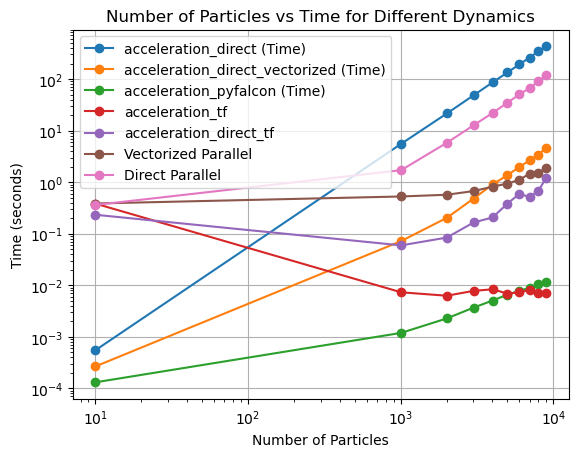

In [27]:
# Plotting non-TensorFlow time results
for facc, label in zip(facc_list,
                       ['acceleration_direct',
                        'acceleration_direct_vectorized',
                        'acceleration_pyfalcon'
                        ]):
    times = [output_results[n]['compile_times'][facc_list.index(facc)] for n in N]
    plt.plot(N, times, marker='o', label=f'{label} (Time)')

# Plotting TensorFlow time results
for facc, label in zip(facc_list_tf, ['acceleration_tf',
                                     'acceleration_direct_tf'
                                     ]):
    times = [output_results_tf[n]['compile_times'][facc_list_tf.index(facc)] for n in N]
    plt.plot(N, times, marker='o', label=f'{label}')

plt.plot(N, times_parallel_vec, label="Vectorized Parallel", marker='o')
plt.plot(N, times_parallel_direct, label="Direct Parallel", marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Particles')
plt.ylabel('Time (seconds)')
plt.title('Number of Particles vs Time for Different Dynamics')
plt.legend()
plt.grid(True)
plt.savefig("9k_particle_vs_time.jpg")
plt.show()


In [21]:
def save_particle_vs_time_data(filename,
                               N,
                               output_results,
                               output_results_tf,
                               times_parallel_vec,
                               times_parallel_direct,
                               facc_list, facc_list_tf
                              ):
    with open(filename, 'w') as file:
        # Write the header
        file.write('Number of Particles, acceleration_direct, acceleration_direct_vectorized, acceleration_pyfalcon, acceleration_tf, acceleration_direct_tf, Vectorized Parallel, Direct Parallel\n')
        
        for i, n in enumerate(N):
            # for non-TensorFlow accelerations
            times = [output_results[n]['compile_times'][facc_list.index(facc)] for facc in facc_list]
            # for TensorFlow accelerations
            times_tf = [output_results_tf[n]['compile_times'][facc_list_tf.index(facc)] for facc in facc_list_tf]
            # for parallel implementations
            time_vec_parallel = times_parallel_vec[i]
            time_direct_parallel = times_parallel_direct[i]
            # Write all times for the current number of particles
            file.write(f'{n}, {times[0]}, {times[1]}, {times[2]}, {times_tf[0]}, {times_tf[1]}, {time_vec_parallel}, {time_direct_parallel}\n')


filename = 'particle_vs_time_data.txt'
save_particle_vs_time_data(filename, N, output_results, output_results_tf, times_parallel_vec, times_parallel_direct, facc_list, facc_list_tf)

In [5]:
!nvidia-smi

Mon Jun  3 19:08:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8               1W /  80W |   4902MiB /  6144MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          44 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   16
  On-line CPU(s) list:    0-15
Vendor ID:                AuthenticAMD
  Model name:             AMD Ryzen 7 4800H with Radeon Graphics
    CPU family:           23
    Model:                96
    Thread(s) per core:   2
    Core(s) per socket:   8
    Socket(s):            1
    Stepping:             1
    Frequency boost:      enabled
    CPU(s) scaling MHz:   52%
    CPU max MHz:          2900.0000
    CPU min MHz:          1400.0000
    BogoMIPS:             5789.59
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall
                           nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep
                          _good nopl nonstop_tsc cpuid extd_apicid aperfmperf r